## Modeling of National Health & Nutrition Examination Survey Data To Predict Whether Someone Has Blood Pressure

This worksheet is used for modeling data from the National Health & Nutrition Examination Survey between the years 2007 - 2016 with the intent of predicting whether someone has high blood pressure.</br>

Target Variable: **High Blood Pressure (binary, yes or no)**</br>

The features that are being considered for this model are:
1. BMI
2. Waist Circumference
3. Height
4. Weight
5. Gender
6. Age
7. Race
8. Frequency of eating out
9. Frequency of eating ready-to-eat meals
10. Frequencey of eating frozen foods
11. Whether smoked cigarettes 100 times in lifetime
12. Current frequency of smoking cigarettes
13. Whether have vigorous activity at work (over 10 min avg daily)
14. Whether have moderate activity at work (over 10 min avg daily)
15. Whether bike or walk to get to and from places 10 min continously each week
16. Wheether do vigorous activity for recreational activity
17. Length of time spent sitting (avg daily)
18. Whether have had more than 12 alcoholic drinks in past year
19. Number of drinks had per day on average for past year
20. Occupation status
21. If have job, number of hours worked in past week

In [321]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

Populating the interactive namespace from numpy and matplotlib


### 1. Pull in cleaned dataset & create dummies
Un-pickle cleaned dataset for NHANES data (created in `data/NHANES_data_collection.ipynb`) to build model for predicting whether someone has high blood pressure (target variable) >

In [76]:
with open('data/pickles/nhanes_clean.pickle','rb') as read_file:
    nhanes_clean = pickle.load(read_file)

In [121]:
# create dummies for two oject columns: race & job status

nhanes_clean = pd.get_dummies(nhanes_clean)

In [122]:
nhanes_clean.columns

Index(['BMI', 'Waist_Circum', 'Height', 'Weight', 'Eat_Out', 'Ready_to_Eat',
       'Frozen_Foods', 'Smoked_Hund', 'Curr_Smoke', 'Work_Vig_Act',
       'Work_Mod_Act', 'Walk_Bike', 'Rec_Vig_Act', 'Sitting_Time', 'Gender',
       'Age', 'Twelve_Alcohol', 'Alcohol_Amt', 'Num_Hrs_Worked_Wk',
       'High_Blood_Pressure', 'Race_Mexican_American',
       'Race_Non_Hispanic_Black', 'Race_Non_Hispanic_White',
       'Race_Other_Hispanic', 'Race_Other_Race', 'Job_Type_have_job',
       'Job_Type_looking_job', 'Job_Type_no_job', 'Job_Type_not_at_work'],
      dtype='object')

-</br>
### 2. Split the data into a Test & Training Set

In [123]:
nhanes_train, nhanes_test = train_test_split(nhanes_clean, test_size=0.2, random_state=42)

In [124]:
y_train = nhanes_train['High_Blood_Pressure'].copy()
y_test = nhanes_test['High_Blood_Pressure'].copy()

X_train = nhanes_train.drop(columns='High_Blood_Pressure').copy()
X_test = nhanes_test.drop(columns='High_Blood_Pressure').copy()

-</br>
### 3. Find the baseline high blood pressure probability
To find a 'baseline' we look at the probability of the 0/1 target for high blood pressure (1 = high blood pressure, 0 = not high blood pressure) for the y_train data.

0    0.650409
1    0.349591
Name: High_Blood_Pressure, dtype: float64


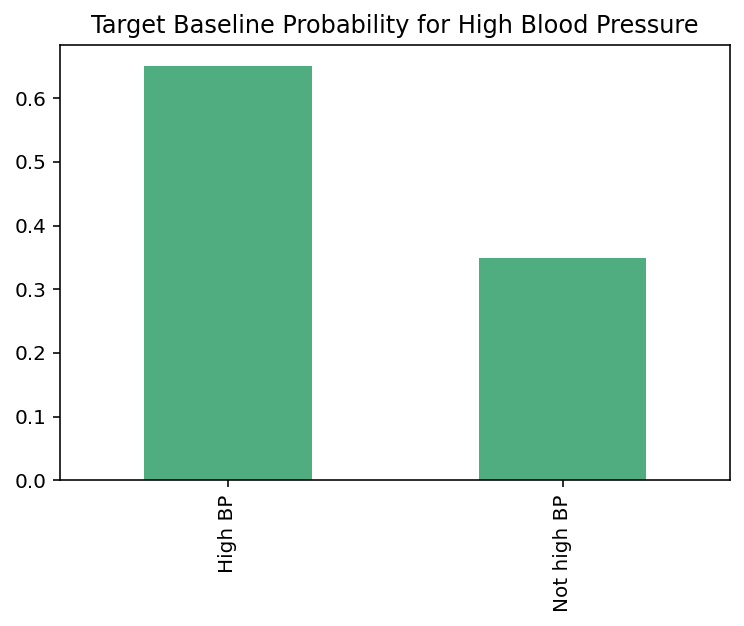

In [125]:
target_train_pcts = y_train.value_counts(normalize=True)
print(target_train_pcts)

xlabels = ['High BP', 'Not high BP']
target_train_pcts.plot(kind='bar', color='#50ad80')
plt.title('Target Baseline Probability for High Blood Pressure')
plt.xticks([0,1],xlabels);

### 4. Examine each variable's relationship to the target

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


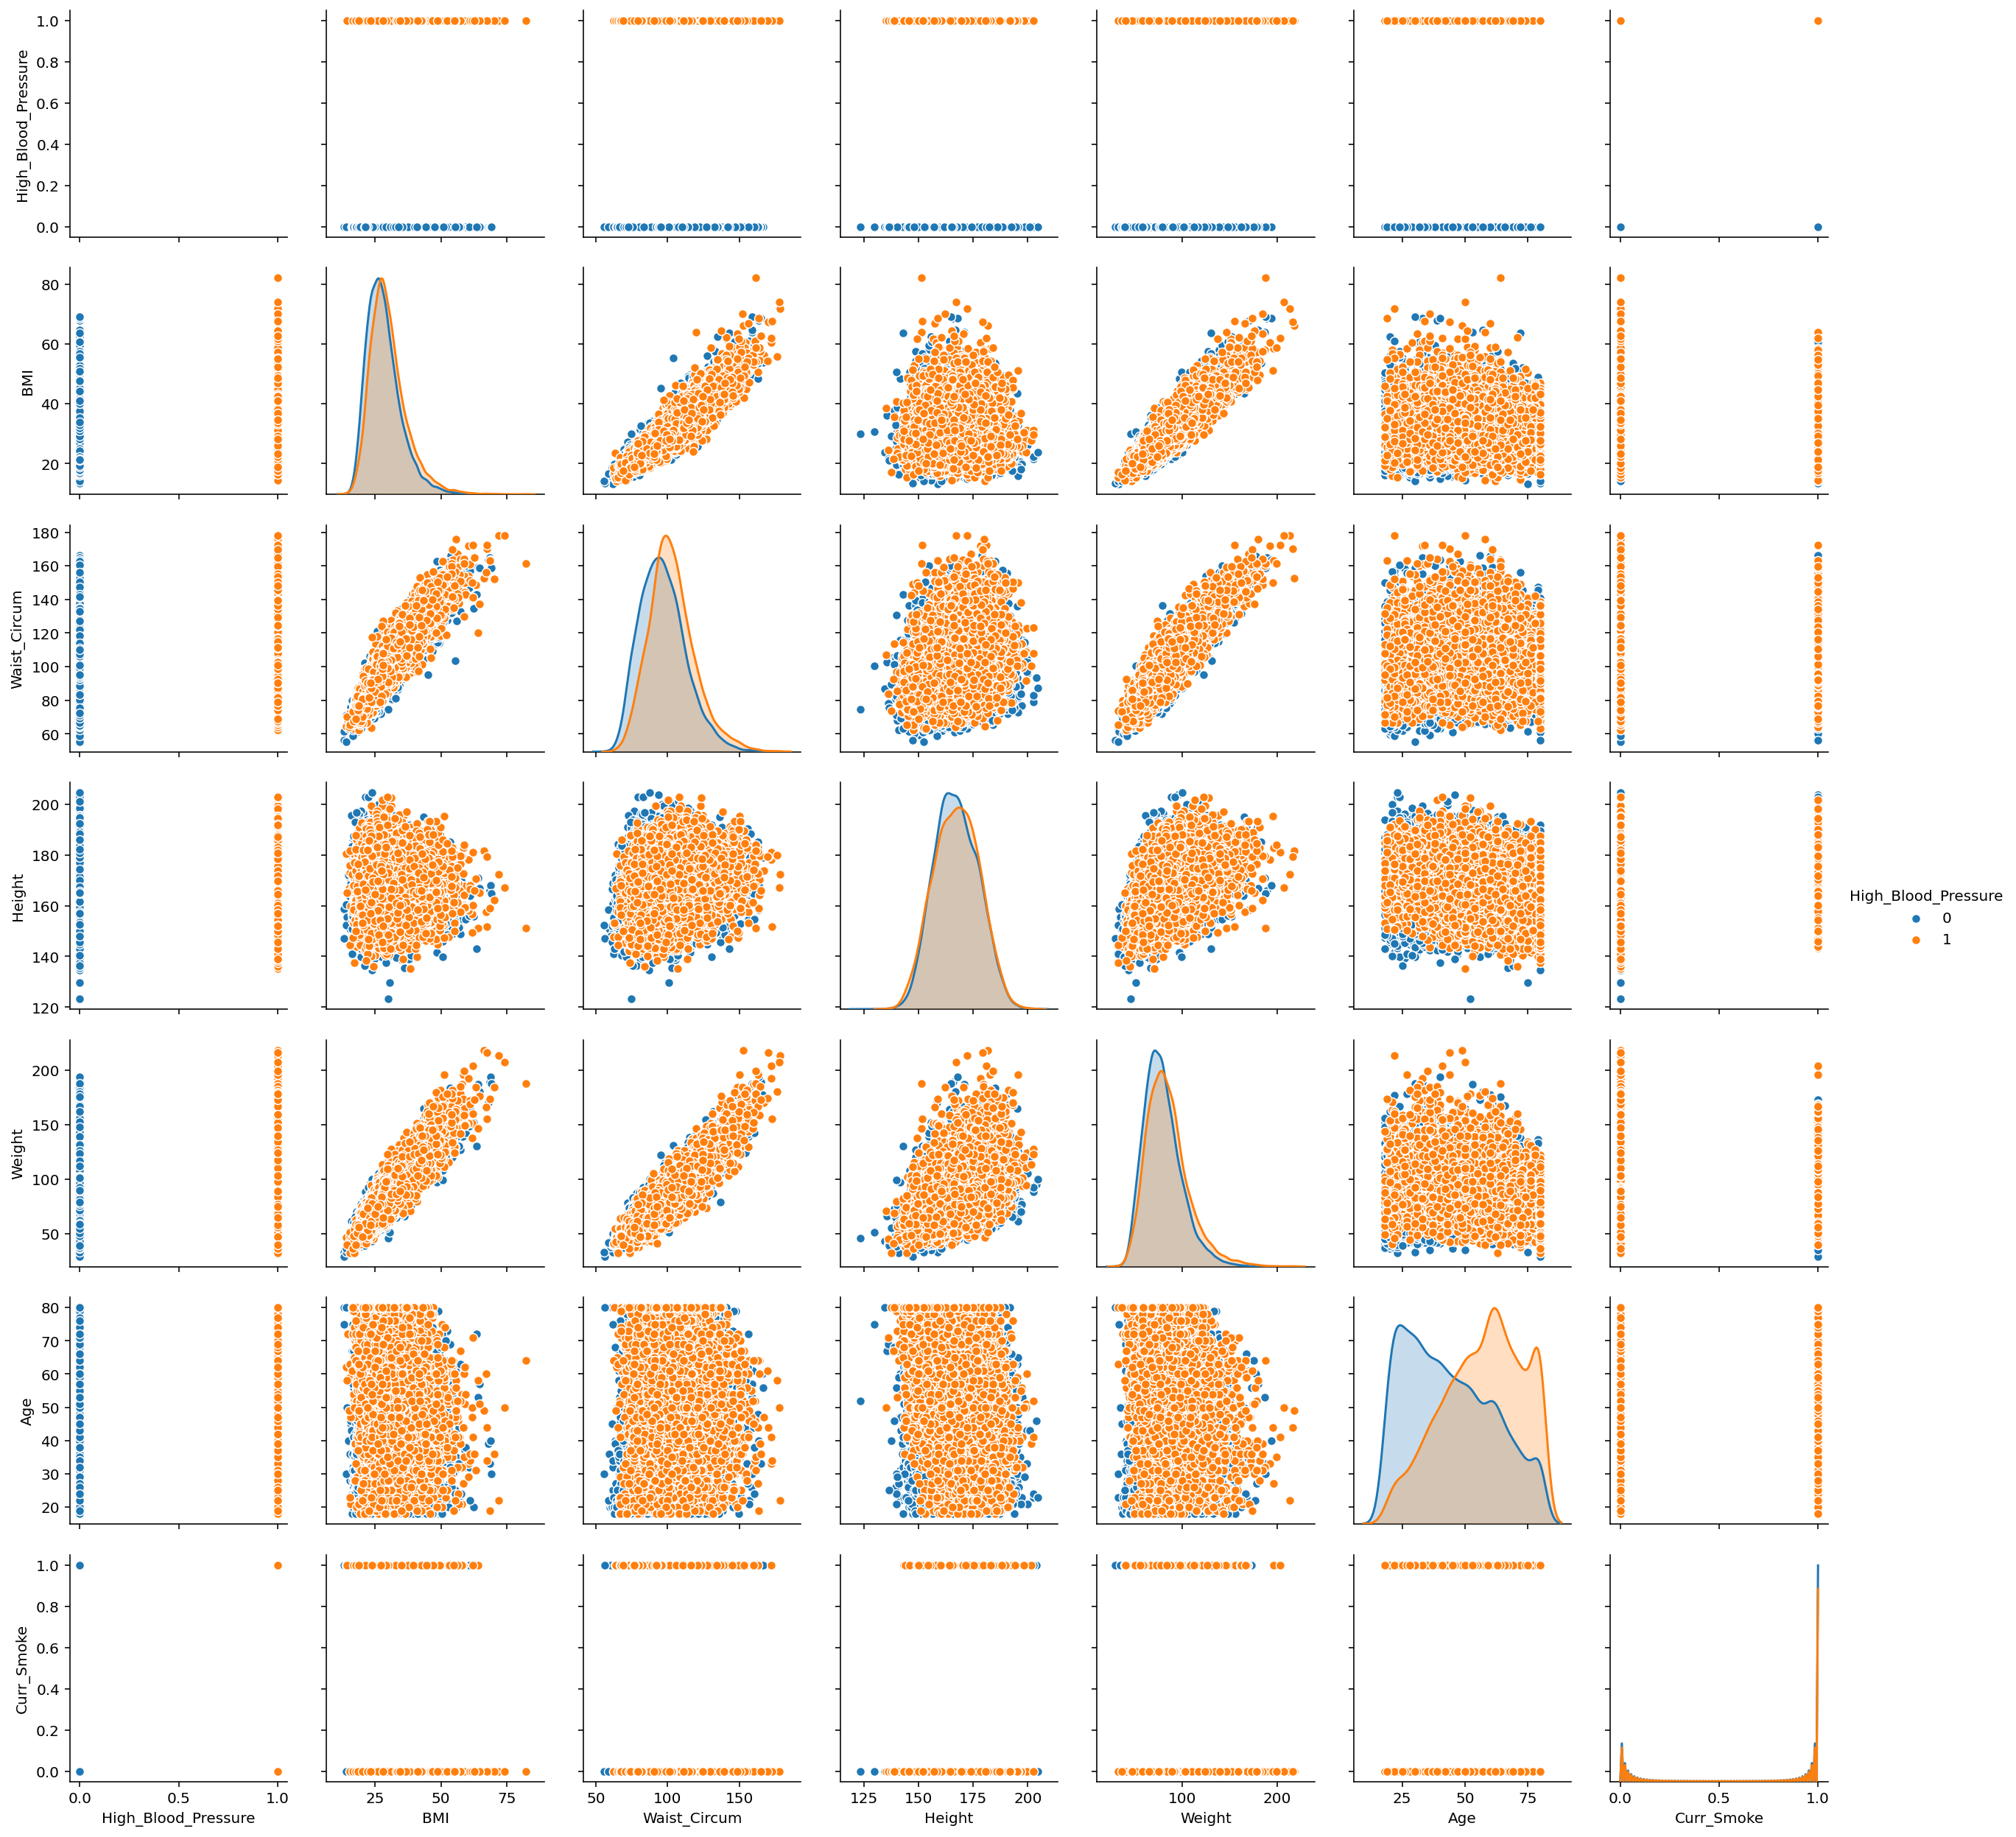

In [126]:
sns.pairplot(nhanes_clean[['High_Blood_Pressure','BMI','Waist_Circum',
                           'Height','Weight','Age','Curr_Smoke']], 
             hue='High_Blood_Pressure');

#### Takeaways:
- **AGE**: Looks like higher age is associated with higher likelihood of a positive target (higher blood pressure) 
- **WAIST CIRCUMFERENCE**: Looks as though higher waist circumference size has slight indication of higher blood pressure
- Remaining features are not that prominent

Take a closer look at the probability in buckets for features we think have relationship with high blood pressure >

In [127]:
def get_emp_prob(target='High_Blood_Pressure', column='Age', min_value=18, max_value=30):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=30, max_value=50))
print(get_emp_prob(min_value=50, max_value=70))
print(get_emp_prob(min_value=70, max_value=90))

0.10563174788444704
0.27465143625062993
0.46336464560204954
0.5739257101238164


In [128]:
def get_emp_prob(target='High_Blood_Pressure', column='Waist_Circum', min_value=60, max_value=80):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=80, max_value=100))
print(get_emp_prob(min_value=100, max_value=120))

0.17874632713026445
0.31313767477012217
0.41528455284552845


Indeed does indicate that Age and Waist Circumference has a relationship with blood pressure.  As each feature increases in size, so does the probability that the person will have high blood pressure


Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


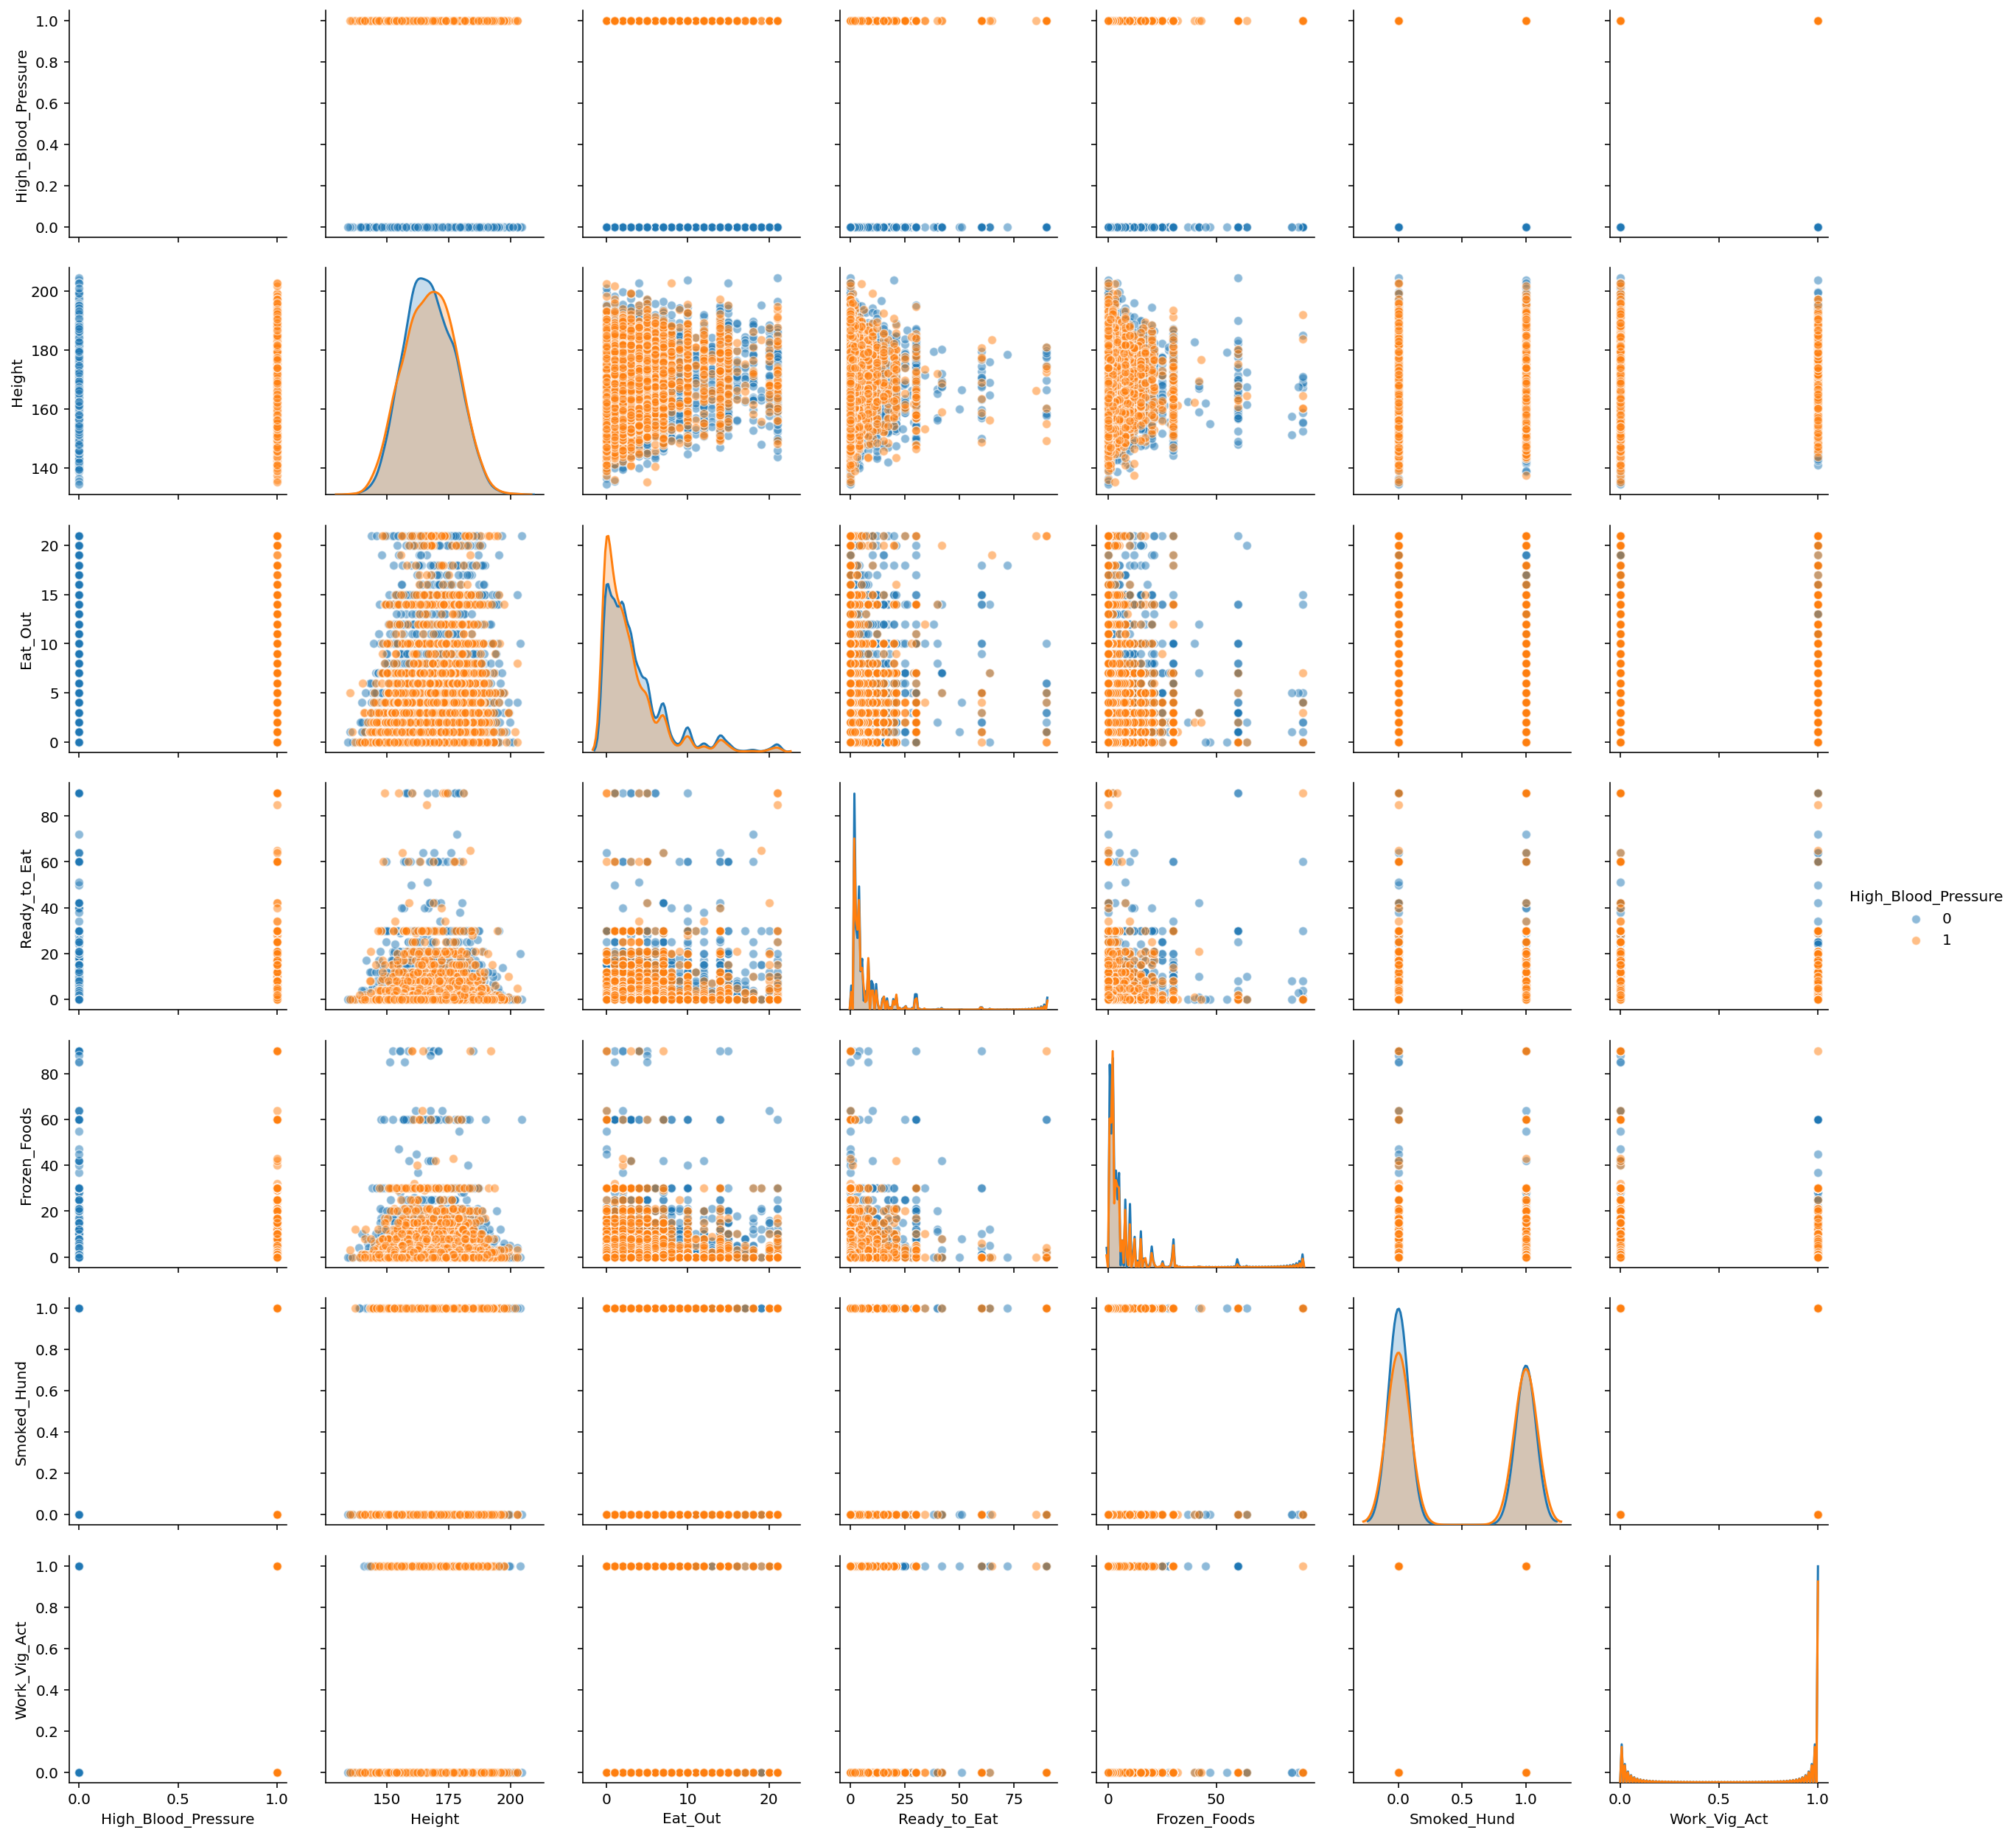

In [94]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Height','Eat_Out',
                           'Ready_to_Eat','Frozen_Foods','Smoked_Hund',
                           'Work_Vig_Act']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Smoked Hundred Cigarettes in Lifetime**: Seems there is a connection with not having smoked more than 100 cigarettes in lifetime and not having high blood pressure

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


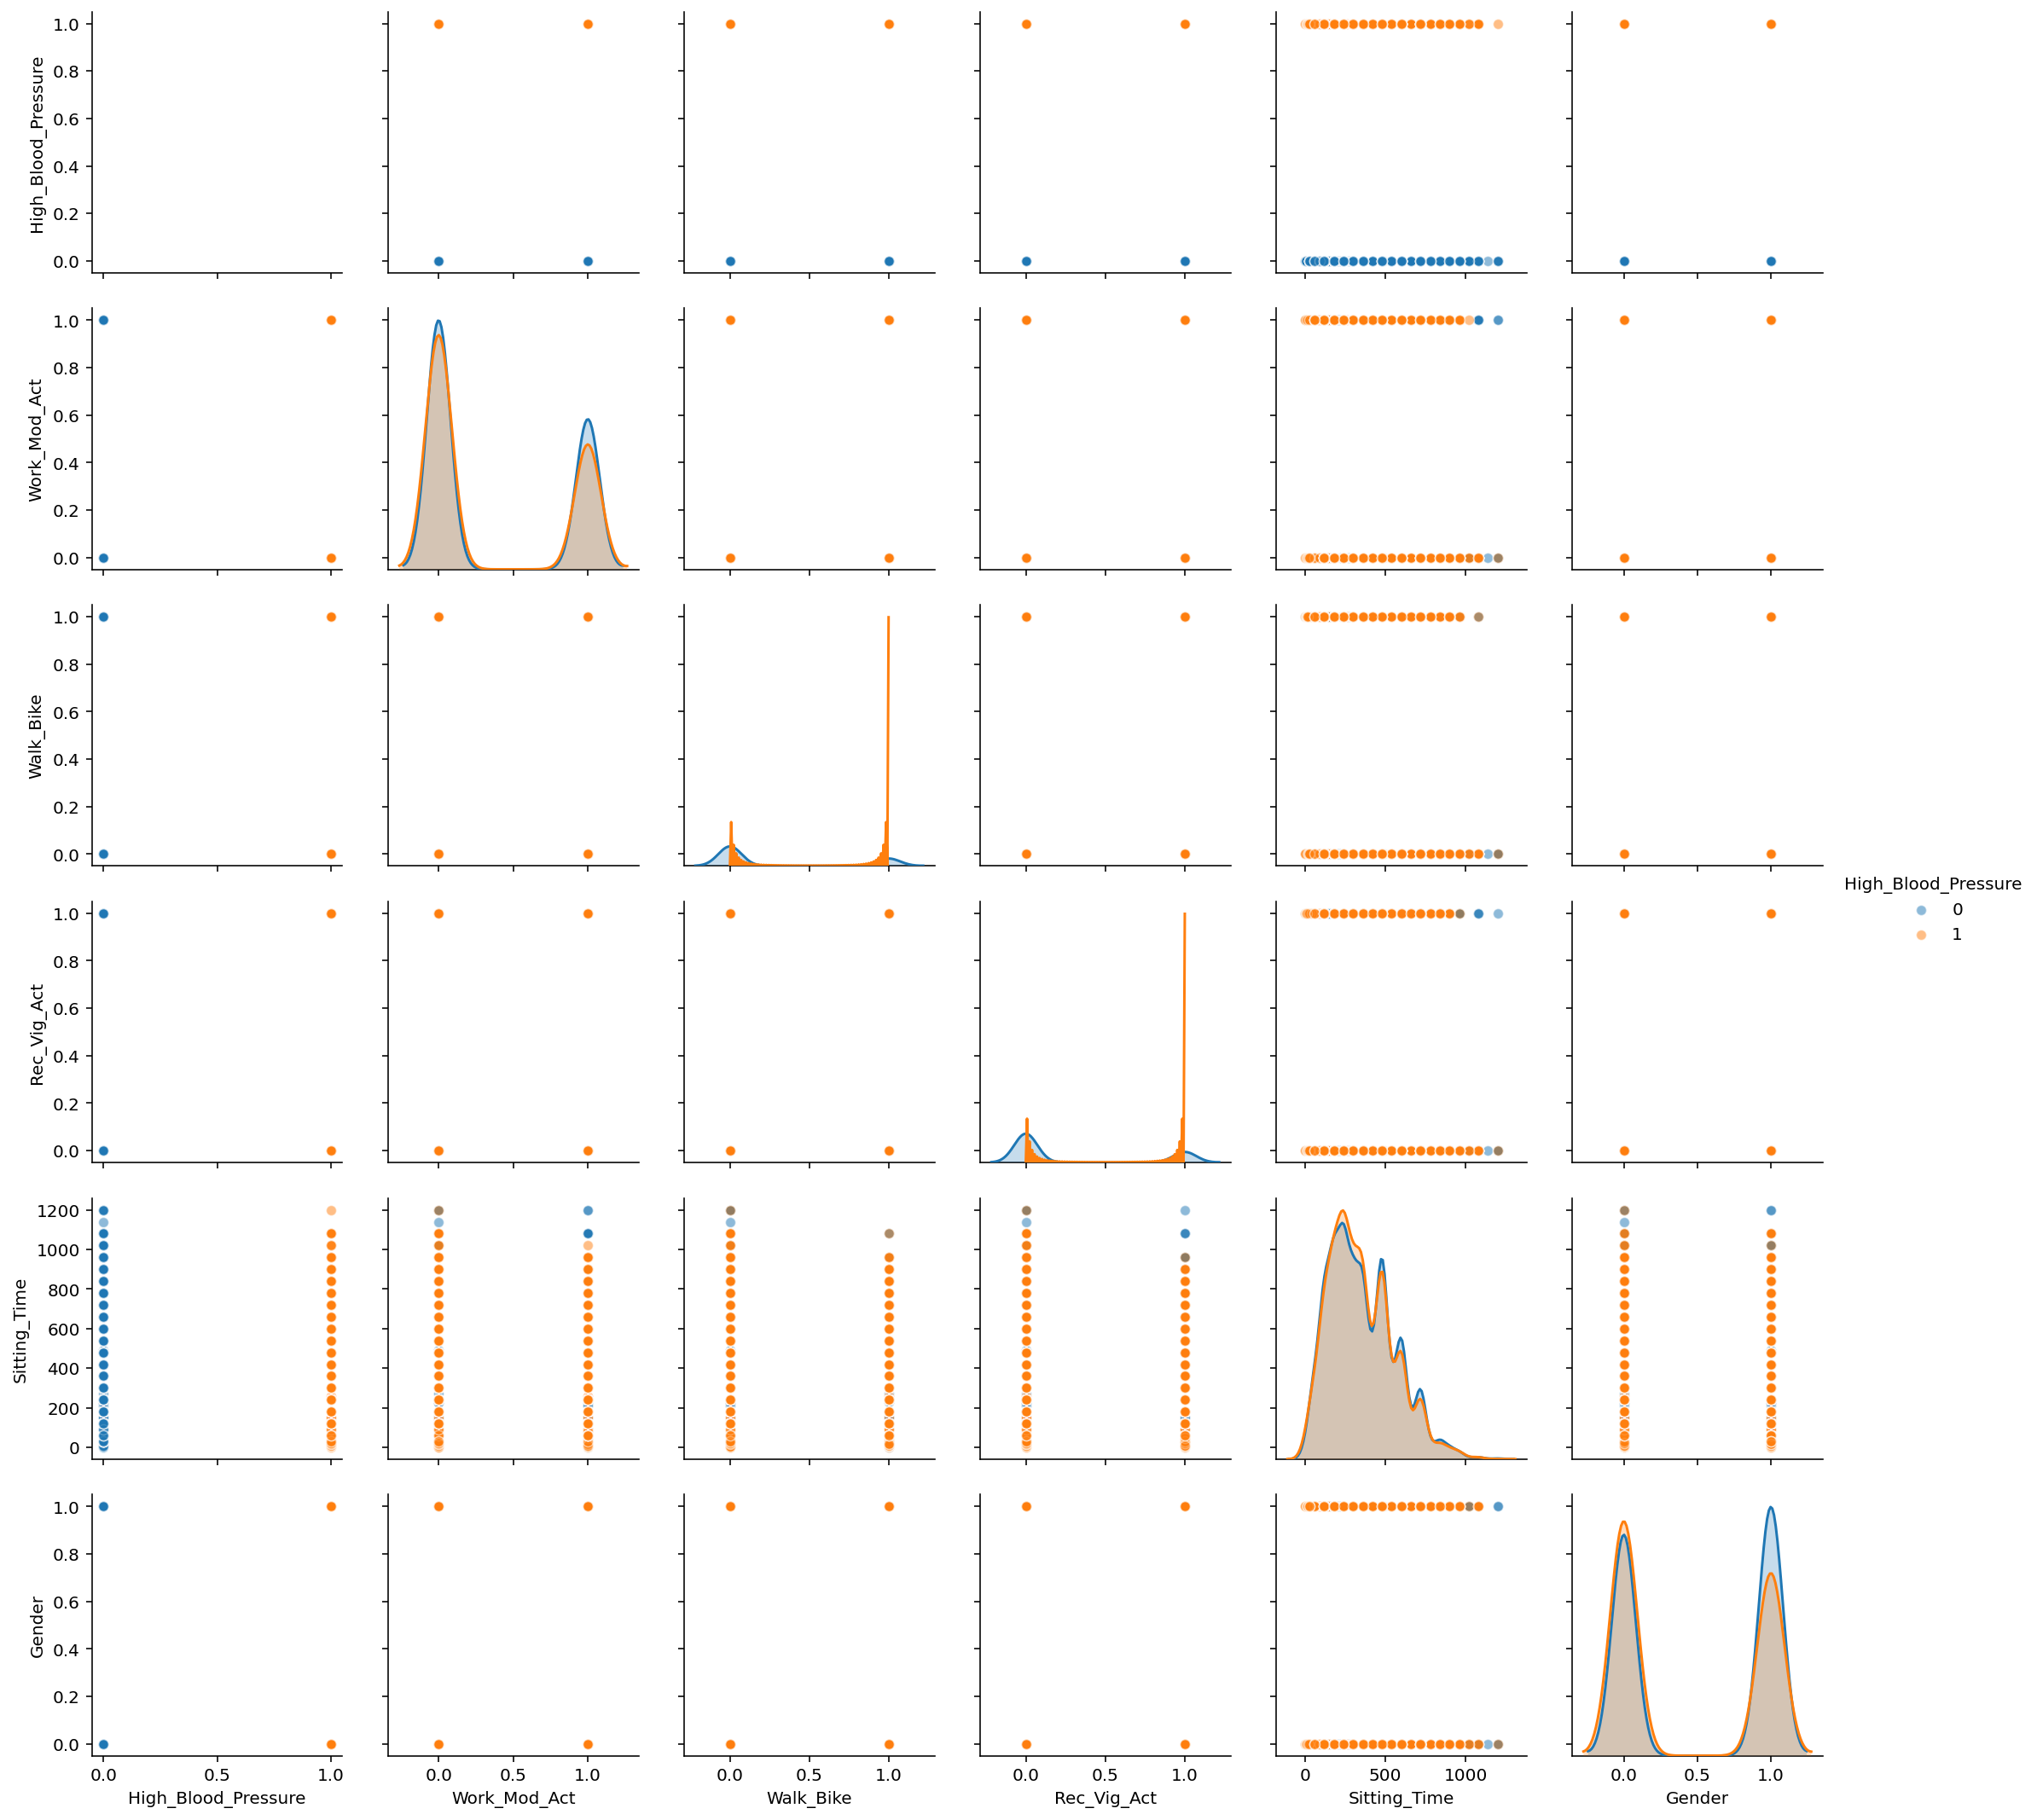

In [130]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Work_Mod_Act','Walk_Bike',
                           'Rec_Vig_Act','Sitting_Time','Gender']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Sitting Time**: There looks like a potential slight connection to higher sitting time and then higher chance of high blood pressure

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


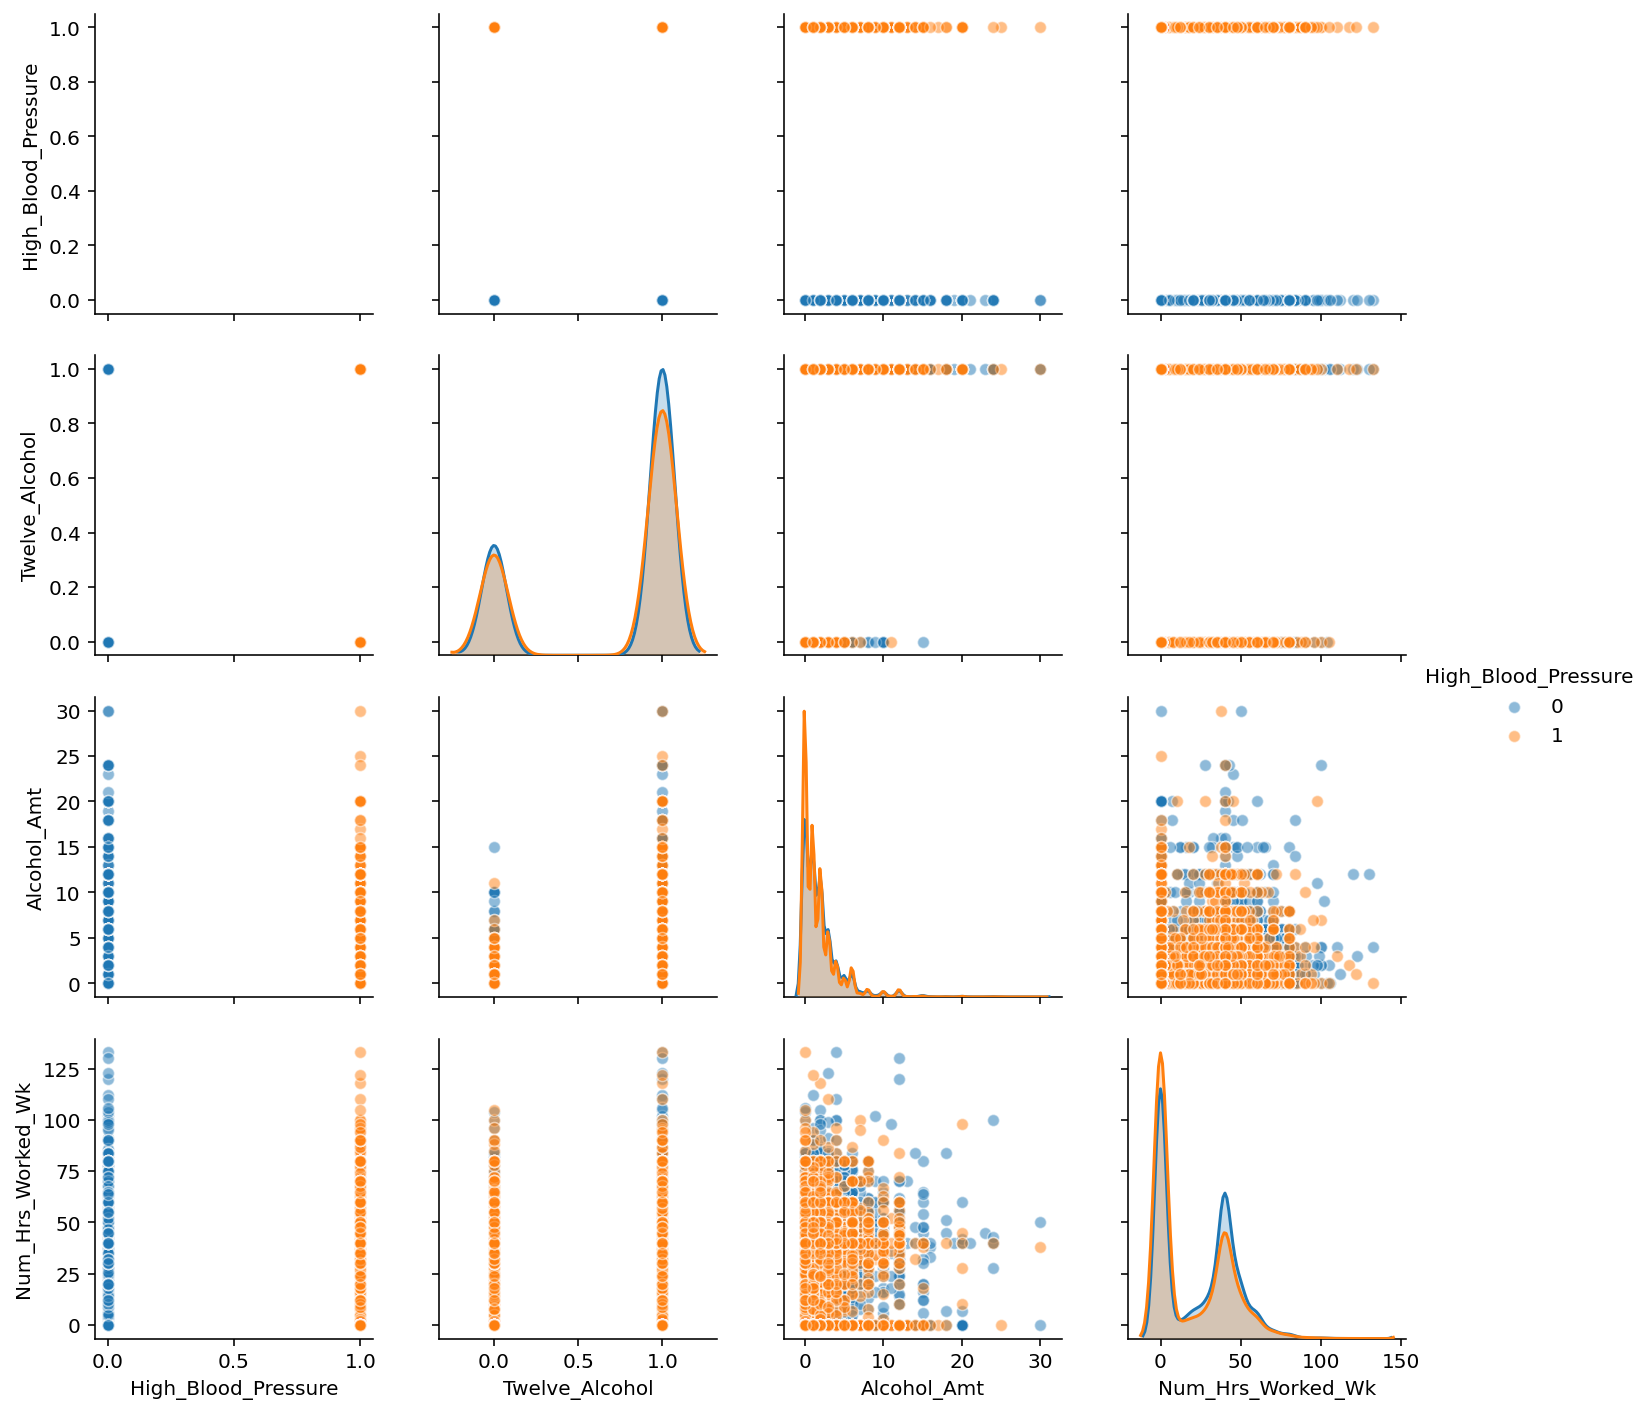

In [92]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Twelve_Alcohol',
                           'Alcohol_Amt','Num_Hrs_Worked_Wk']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Alcohol Amount**: Hard to tell clearly from graph, but seems there is a potential relationship between drinking more alcohol and having high blood pressure

## BUILDING & OPTIMIZING MODELS

#### MODEL 1: Logistic Regression - minimal features

In [179]:
std_scale = StandardScaler()

v1_features = ['Age', 'Waist_Circum']

X_train_v1 = X_train[v1_features]
X_train_scaled_v1 = std_scale.fit_transform(X_train_v1)

lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_scaled_v1, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [180]:
print('SCORE for v1 Model:')
lm1.score(X_train_scaled_v1, y_train)

SCORE for v1 Model:


0.6744897391691229

In [171]:
print('COEFFICIENTS for v1 Model:')
cofficients_v1 = dict(zip(X_train_v1.columns, [x for nest in lm1.coef_ for x in nest]))
cofficients_v1


COEFFICIENTS for v1 Model:


{'Age': 0.7403993957833136, 'Waist_Circum': 0.29694952564900123}

In [175]:
print('INTERCEPT for v1 Model:')
print(lm1.intercept_)

INTERCEPT for v1 Model:
[-0.7262199]


-</br>
#### MODEL 2: Logistic Regression - additional features

In [181]:
X_train.columns

Index(['BMI', 'Waist_Circum', 'Height', 'Weight', 'Eat_Out', 'Ready_to_Eat',
       'Frozen_Foods', 'Smoked_Hund', 'Curr_Smoke', 'Work_Vig_Act',
       'Work_Mod_Act', 'Walk_Bike', 'Rec_Vig_Act', 'Sitting_Time', 'Gender',
       'Age', 'Twelve_Alcohol', 'Alcohol_Amt', 'Num_Hrs_Worked_Wk',
       'Race_Mexican_American', 'Race_Non_Hispanic_Black',
       'Race_Non_Hispanic_White', 'Race_Other_Hispanic', 'Race_Other_Race',
       'Job_Type_have_job', 'Job_Type_looking_job', 'Job_Type_no_job',
       'Job_Type_not_at_work'],
      dtype='object')

In [317]:
std_scale = StandardScaler()

v2_features = ['Age','Weight','Alcohol_Amt',
               'Race_Non_Hispanic_Black','Job_Type_have_job'
              ]

X_train_v2 = X_train[v2_features]
X_train_scaled_v2 = std_scale.fit_transform(X_train_v2)

lm2 = LogisticRegression(solver='liblinear')
lm2.fit(X_train_scaled_v2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [318]:
print('SCORE for v2 Model:')
lm2.score(X_train_scaled_v2, y_train)

SCORE for v2 Model:


0.6842778488404427

In [319]:
print('COEFFICIENTS for v2 Model:')
cofficients_v2 = dict(zip(X_train_v2.columns, [x for nest in lm2.coef_ for x in nest]))
cofficients_v2

COEFFICIENTS for v2 Model:


{'Age': 0.8757905956735766,
 'Weight': 0.29406955984011884,
 'Alcohol_Amt': 0.1270971865279981,
 'Race_Non_Hispanic_Black': 0.19540898799719025,
 'Job_Type_have_job': 0.03129692850586297}

In [349]:
blood_pressure = (X_train_scaled_v2)
predictions = lm2.predict(blood_pressure)
confusion_matrix(y_train, predictions)

array([[9753, 1942],
       [3735, 2551]])

# NEED HELP: When and how to un-scale?

In [351]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test[v2_features])[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'high'],
           yticklabels=['legit', 'high']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

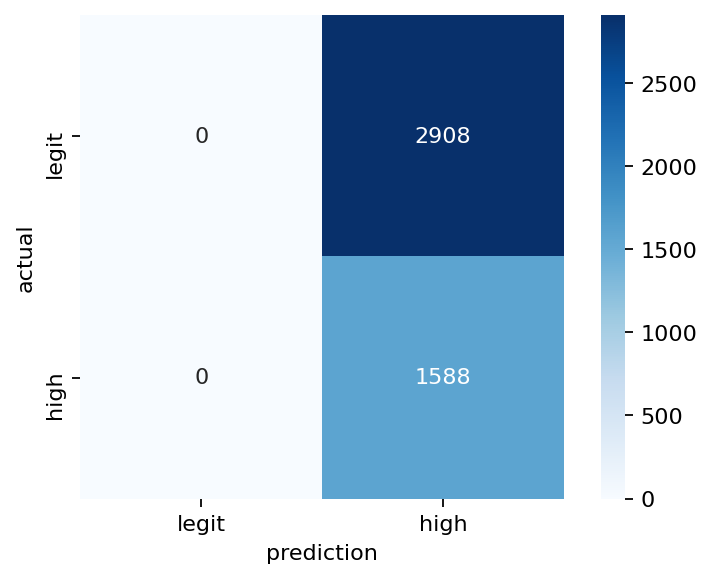

In [348]:
make_confusion_matrix(lm2)

In [352]:
lm2.predict_proba(X_train_scaled_v2)

array([[0.52649352, 0.47350648],
       [0.70228369, 0.29771631],
       [0.56285214, 0.43714786],
       ...,
       [0.52039451, 0.47960549],
       [0.65753368, 0.34246632],
       [0.3431528 , 0.6568472 ]])

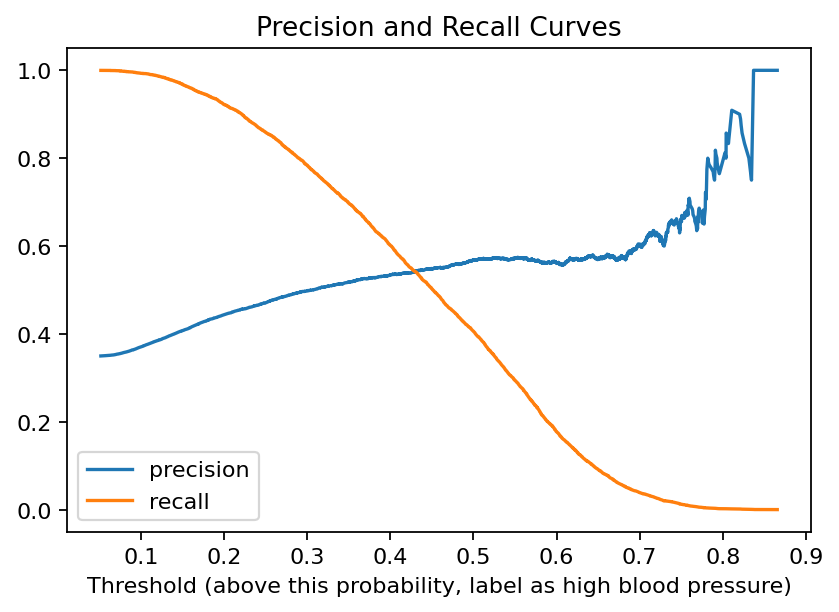

In [358]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, lm2.predict_proba(X_train_scaled_v2)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as high blood pressure)');
plt.title('Precision and Recall Curves');

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])